# Lettura grafo con dataframe

In [1]:
import networkx as nx
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pyvis.network import Network
from IPython.display import IFrame

# 1. Configurazione file
# Usa il nome del file generato dal tuo script di raccolta
filename = "private/dataset_snowball.gexf" 

try:
    G = nx.read_gexf(filename)
    print(f"✅ Grafo caricato! Nodi: {G.number_of_nodes()}, Archi: {G.number_of_edges()}")
except Exception as e:
    print(f"❌ Errore nel caricamento: {e}")

# Estrazione archi in DataFrame per analisi statistica
data_archi = []
for source, target, attr in G.edges(data=True):
    data_archi.append({
        'Source': source,
        'Target': target,
        'Magnete': attr.get('trigger_text', ''),
        'Reazione': attr.get('reply_content', '')
    })
df_edges = pd.DataFrame(data_archi)

✅ Grafo caricato! Nodi: 776, Archi: 795


# Calcolo sentiment

In [2]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not text: return 0.0
    return float(analyzer.polarity_scores(text)['compound'])

print("🧠 Calcolo sentiment (ottimizzato su testi unici)...")

# Sentiment Magneti (Post Originali)
unique_m = pd.Series(df_edges['Magnete'].unique())
m_map = dict(zip(unique_m, [get_sentiment(t) for t in tqdm(unique_m, desc="Magneti")]))
df_edges['sentiment_magnete'] = df_edges['Magnete'].map(m_map)

# Sentiment Reazioni (Risposte)
unique_r = pd.Series(df_edges['Reazione'].unique())
r_map = dict(zip(unique_r, [get_sentiment(t) for t in tqdm(unique_r, desc="Reazioni")]))
df_edges['sentiment_reazione'] = df_edges['Reazione'].map(r_map)

print("✅ Sentiment calcolato con successo.")

🧠 Calcolo sentiment (ottimizzato su testi unici)...


Reazioni: 100%|██████████| 756/756 [00:00<00:00, 23177.35it/s]

✅ Sentiment calcolato con successo.


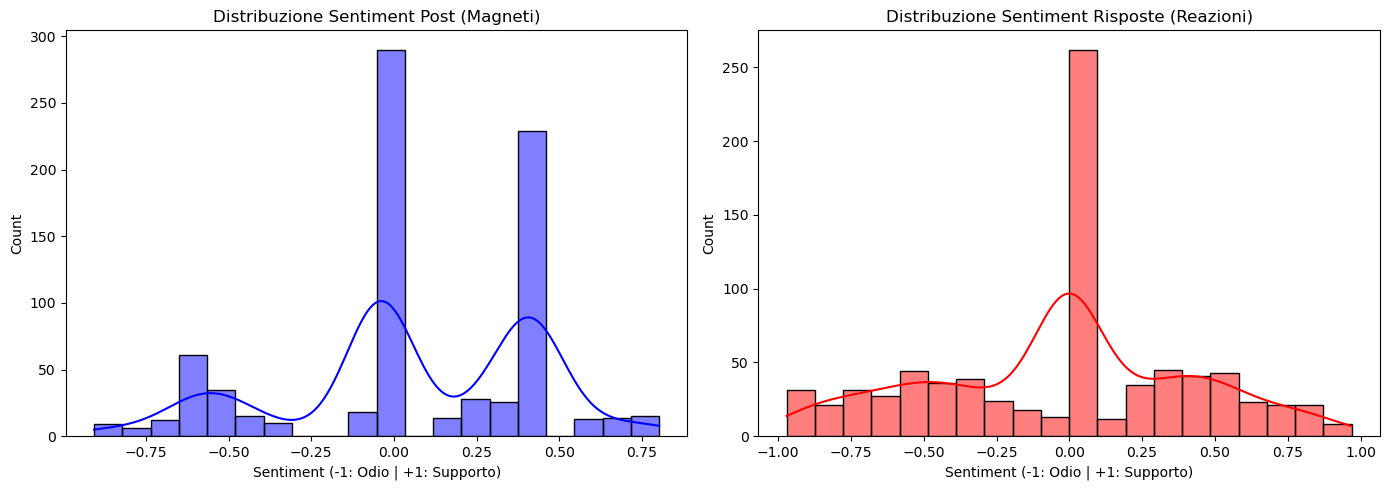

In [3]:
plt.figure(figsize=(14, 5))

# Istogramma Magneti
plt.subplot(1, 2, 1)
sns.histplot(df_edges['sentiment_magnete'], bins=20, kde=True, color='blue')
plt.title("Distribuzione Sentiment Post (Magneti)")
plt.xlabel("Sentiment (-1: Odio | +1: Supporto)")

# Istogramma Reazioni
plt.subplot(1, 2, 2)
sns.histplot(df_edges['sentiment_reazione'], bins=20, kde=True, color='red')
plt.title("Distribuzione Sentiment Risposte (Reazioni)")
plt.xlabel("Sentiment (-1: Odio | +1: Supporto)")

plt.tight_layout()
plt.show()

# aggiunta sentiment al grafo G e salvataggio

In [4]:
print("💉 Iniezione attributi float nel grafo G...")

for u, v, attr in G.edges(data=True):
    txt_m = attr.get('trigger_text', '')
    txt_r = attr.get('reply_content', '')
    
    # Forziamo il tipo float per Gephi Ranking
    attr['sentiment_magnete'] = float(m_map.get(txt_m, 0.0))
    attr['sentiment_reazione'] = float(r_map.get(txt_r, 0.0))

# Salvataggio file finale
output_gephi = "dataset_sentiment_final.gexf"
nx.write_gexf(G, output_gephi)
print(f"💾 File salvato: {output_gephi}. Ora puoi aprirlo in Gephi!")

💉 Iniezione attributi float nel grafo G...
💾 File salvato: dataset_sentiment_final.gexf. Ora puoi aprirlo in Gephi!


# Visualizzatore

In [ ]:
print("🌐 Generazione visualizzazione interattiva...")

# Se il grafo è troppo grande, filtriamo i nodi principali
nodi_rilevanti = [n for n, d in G.in_degree() if d > 2] # Mostra solo chi ha almeno 2 risposte
G_sub = G.subgraph(nodi_rilevanti)

net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='remote')
net.from_nx(G_sub)
net.toggle_physics(True)

# Salvataggio e visualizzazione forzata tramite IFrame
net.save_graph("visualizzazione_grafo.html")
IFrame(src='./visualizzazione_grafo.html', width='100%', height='750px')